# Gradient Boosting Regressor

In [17]:
# Basic libraries
import geopandas as gpd
import pandas as pd
import numpy as np
import pickle
import warnings
import time

import seaborn as sns
import matplotlib.pyplot as plt

# Modeling
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.feature_selection import SequentialFeatureSelector

# Metrics
from sklearn import metrics
from sklearn.decomposition import PCA

In [4]:
# Options
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Modeling

Gradient boosting is an ensemble model that use boosting methods to optimize the loss function (squared error) of the generalized model.  Boosting methods operate in a stage-like fashion, and in gradient boosting a series of weak learners, typically decision tress, are created that iteratively build upon the preceeding learner to optimize the loss function in the final model. For instance, an initial weak learner is created that predicts HA Amount using some constant, in the next iteration a new weaker learner is created that is fitted to the residuals of the previous learner and so on and so forth.  The result is an ensemble model that minimizes the loss function using a gradient descent algorithm, hence the name Gradient Boosting.

The following hyperparameters will be tuned for model optimization:
 - n-estimators: the number of weak learners (estimators) that will be used in the iterative boosting process
 - learning rate: shrinks the contribution of each tree.  Smaller learning rates are associated with improved generalizability but come at computational cost, as lower learning rates require greater iterations.

In [5]:
# Load FL/TX data
df = pd.read_csv("../data/open-fema/FEMA-Large-Demographics-FL-TX.csv")

In [21]:
def gradient_boost(data=df, n_estimators=100, learning_rate=1, max_depth=3):
    
    # Split the data into train and test data
    X = data.loc[:, data.columns != 'haAmount']
    y = data.loc[:, 'haAmount']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state=42)

    # Gradient Boosting - fit the model
    gbm = GradientBoostingRegressor(n_estimators=n_estimators,
                                    learning_rate=learning_rate,
                                    max_depth=max_depth,
                                    random_state=0)
    gbm.fit(X_train, y_train)

    # Predict
    y_pred = gbm.predict(X_test)
    
    # Parameters and results
    print('Gradient Boosting Regressor')
    print('Features: {}'.format(X_train.shape[1]))
    print('R^2 score: {:.4f}'.format(metrics.r2_score(y_test, y_pred)))
    print('MAE: {:.2f}'.format(metrics.mean_absolute_error(y_test, y_pred)))
    print('MSE: {:.2f}'.format(metrics.mean_squared_error(y_test, y_pred)))
    print('RMSE: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))
    
    return(gbm)

### FEMA Only

In [22]:
def transform_fema(data):
    '''Specified transforms are applied to the data in advance
    of the modeling stage, feature engineering and/or scaling,
    Accepts input of dataframe, outputs transformed dataframe.
    '''
    
    # Define columns
    cols = ['householdComposition', 'specialNeeds', 'homeOwnersInsurance', 'floodInsurance', 'inspected',
            'rpfvl', 'habitabilityRepairsRequired', 'destroyed', 'waterLevel', 'floodDamage',
            'foundationDamage', 'roofDamage', 'tsaEligible', 'rentalAssistanceEligible', 'repairAssistanceEligible',
            'replacementAssistanceEligible', 'sbaEligible', 'primaryResidence', 'haAmount', 'ownRent_Owner',
            'ownRent_Renter', 'ownRent_Unknown', 'residenceType_Apartment', 'residenceType_Assisted Living Facility',
            'residenceType_Boat', 'residenceType_College Dorm', 'residenceType_Condo',
            'residenceType_Correctional Facility', 'residenceType_House/Duplex', 'residenceType_Military Housing',
            'residenceType_Mobile Home', 'residenceType_Other', 'residenceType_Townhouse',
            'residenceType_Travel Trailer' ,'residenceType_Unknown']
    
    # Select columns
    data = data.loc[:, cols]
    
    return(data)

In [24]:
# Transform
df_fema = transform_fema(df)

# GradientBoost with Fema only
gbm = gradient_boost(data=df_fema, n_estimators=100,
                                   learning_rate=1,
                                   max_depth=3)

# Save the model
pickle.dump(gbm, open('gbm-fema-first.sav', 'wb'))

Gradient Boosting Regressor
Features: 34
R^2 score: 0.9475
MAE: 91.88
MSE: 330067.43
RMSE: 574.51


In [25]:
# Load saved model
gbm = pickle.load(open('gbm-fema-first.sav', 'rb'))
print(gbm)

GradientBoostingRegressor(learning_rate=1, random_state=0)


In [ ]:
def plot_importance(data, model):

    # Feature importance
    df_trim = data.loc[:, data.columns != 'haAmount']
    importance = pd.DataFrame({'feature': df_trim.columns, 'importance': model.feature_importances_})
    importance.sort_values(by='importance', ascending=True, inplace=True)
    trimmed_features = importance.loc[importance['importance'] > 0.001]
    
    # Plot feature importance
    fig, ax = plt.subplots(figsize = (6,6))
    ax.barh(trimmed_features['feature'], trimmed_features['importance'])
    ax.set_title('AdaBoost: Feature Importance (n-estimators={})'.format(model.get_params()['n_estimators']))
    ax.set_ylabel('Importance')
    ax.set_xlabel('Features')
    
    # Sort descending
    importance.sort_values(by='importance', ascending=False, inplace=True)
    
    return(importance)

# Plot importance
ada_best_features = plot_importance(data=df_fema, model=ada_best)

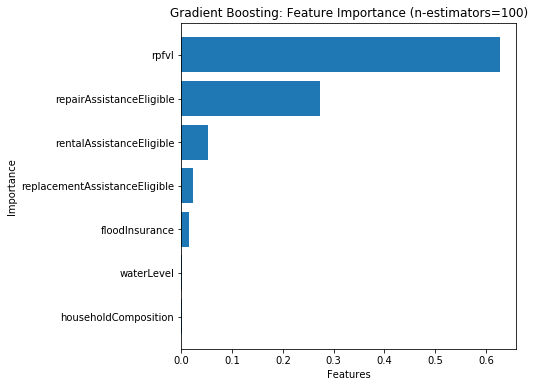

In [84]:
# Plot importance
gbm_features = plot_importance(data=df_fema, model=gbm)

In [42]:
def plot_residuals(data, model):
    
    # Split the data into train and test data
    X = data.loc[:, data.columns != 'haAmount']
    y = data.loc[:, 'haAmount']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state=42)
             
    # Predict
    y_pred = gbm.predict(X_test)

    # Plot residuals
    fig, ax = plt.subplots(figsize = (7,4.5))
    ax.scatter(y_pred, y_pred - y_test, color='black', s=20)
    ax.hlines(y=0, xmin= -30000, xmax=45000, colors='red')

    ax.set_title('Residuals: Variance of Fitted Values')
    ax.set_xlabel('Predicted HA Amount')
    ax.set_ylabel('Variance from actual')

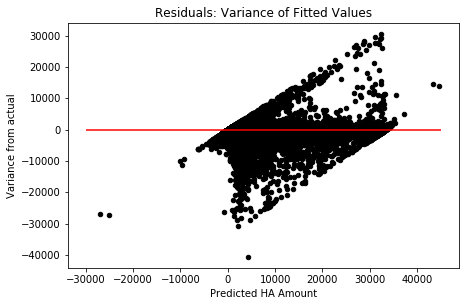

In [43]:
# PLot residuals
plot_residuals(data=df_fema, model=gbm)

### Grid Search - FEMA Only

In [61]:
def gradient_boost_optimizer(data=df):
    '''Fit GridSearchCV using GradientBoosting regression for various
    parameters. Accepts input of full_data and returns (prints)
    the best model score and corresponding parameters.
    '''
    
    # Start time
    start_time = time.time()
    
    # Split the data into train and test data
    X = data.loc[:, data.columns != 'haAmount']
    y = data.loc[:, 'haAmount']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state=42)

    # Parameters
    model = GradientBoostingRegressor(random_state=0)
    param_grid = {'n_estimators': np.array([100, 150, 200]),
                  'learning_rate': np.array([0.01, 0.1, 0.5]),
                  'max_depth': np.array([3, 6]),
                  'criterion': ['friedman_mse']}
    
    # Fit grid search
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
    grid_search.fit(X_train, y_train)

    # Make predictions
    y_pred = grid_search.predict(X_test)

    # summarize the results of the grid search
    print('AdaBoost Regressor')
    print('Best score: {:.3f}'.format(grid_search.best_score_))
    print('Best estimator: {}'.format(grid_search.best_estimator_.n_estimators))
    print('Best learning rate: {:.2f}'.format(grid_search.best_estimator_.learning_rate))
    print('Best depth: {}'.format(grid_search.best_estimator_.max_depth))
    print('Best loss: {}'.format(grid_search.best_estimator_.loss))
    
    print('\nTime (seconds): {:.0f} '.format(time.time() - start_time))
    print('Time (minutes): {:.1f}'.format((time.time() - start_time)/60))
    
    return(grid_search)

In [62]:
# GridSearch - Fema only
gradient_boost_optimizer(df_fema)

AdaBoost Regressor
Best score: 0.953
Best estimator: 100
Best learning rate: 0.10
Best depth: 100
Best loss: ls

Time (seconds): 43173 
Time (minutes): 719.6


GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=0),
             param_grid={'criterion': ['friedman_mse'],
                         'learning_rate': array([0.01, 0.1 , 0.5 ]),
                         'max_depth': array([3, 6]),
                         'n_estimators': array([100, 150, 200])})

### FEMA Only - Gradient Boosting Best Model

In [64]:
# GradientBoost with Fema only
gbm_best = gradient_boost(data=df_fema, n_estimators=100,
                                        learning_rate=0.1,
                                        max_depth=6)

# Save the model
pickle.dump(gbm_best, open('gbm-fema.sav', 'wb'))

Gradient Boosting Regressor
Features: 34
R^2 score: 0.9529
MAE: 75.71
MSE: 296119.90
RMSE: 544.17


In [65]:
# Load saved model
gbm_best = pickle.load(open('gbm-fema.sav', 'rb'))
print(gbm_best)

GradientBoostingRegressor(max_depth=6, random_state=0)


### FEMA with Basic Demographics 

In [66]:
def transform_demo_basic(data):
    '''Specified transforms are applied to the data in advance
    of the modeling stage, feature engineering and/or scaling,
    Accepts input of dataframe, outputs transformed dataframe.'''
    
    # Define columns
    cols = ['householdComposition', 'specialNeeds', 'homeOwnersInsurance', 'floodInsurance', 'inspected',
            'rpfvl', 'habitabilityRepairsRequired', 'destroyed', 'waterLevel', 'floodDamage',
            'foundationDamage', 'roofDamage', 'tsaEligible', 'rentalAssistanceEligible', 'repairAssistanceEligible',
            'replacementAssistanceEligible', 'sbaEligible', 'primaryResidence', 'haAmount', 'ownRent_Owner',
            'ownRent_Renter', 'ownRent_Unknown', 'residenceType_Apartment', 'residenceType_Assisted Living Facility',
            'residenceType_Boat', 'residenceType_College Dorm', 'residenceType_Condo',
            'residenceType_Correctional Facility', 'residenceType_House/Duplex', 'residenceType_Military Housing',
            'residenceType_Mobile Home', 'residenceType_Other', 'residenceType_Townhouse',
            'residenceType_Travel Trailer' ,'residenceType_Unknown', 'below_poverty_rate', 'median_earnings_total',
            'unemployed_labor_rate', 'built_1979_or_earlier_rate', 'owner_occupied_rate']
    
    # Select columns
    data = data.loc[:, cols]
    
    return(data)

In [67]:
# Transform
df_demo = transform_demo_basic(df)

# AdaBoost with basic demographics
gbm_demo = gradient_boost(data=df_demo, n_estimators=100,
                                        learning_rate=0.1,
                                        max_depth=6)

# Save the model
pickle.dump(gbm_demo, open('gbm-demo.sav', 'wb'))

Gradient Boosting Regressor
Features: 39
R^2 score: 0.9536
MAE: 72.71
MSE: 291527.91
RMSE: 539.93


In [79]:
# Load saved model
gbm_demo = pickle.load(open('gbm-demo.sav', 'rb'))
print(gbm_demo)

GradientBoostingRegressor(max_depth=6, random_state=0)


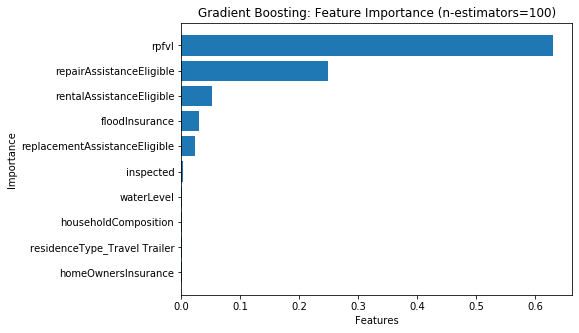

In [80]:
# Plot importance
gbm_demo_features = plot_importance(data=df_demo, model=gbm_demo)

In [ ]:
### Grid Search - FEMA with Demographics

In [ ]:
# GridSearch - Fema with demographics
#gbmboost_optimizer(df_demo)

### FEMA with DVI

In [72]:
def transform_demo_dvi(data):
    '''Specified transforms are applied to the data in advance
    of the modeling stage, feature engineering and/or scaling,
    Accepts input of dataframe, outputs transformed dataframe.'''
   
    # Define columns
    cols = ['householdComposition', 'specialNeeds', 'homeOwnersInsurance', 'floodInsurance', 'inspected',
           'rpfvl', 'habitabilityRepairsRequired', 'destroyed', 'waterLevel', 'floodDamage',
           'foundationDamage', 'roofDamage', 'tsaEligible', 'rentalAssistanceEligible', 'repairAssistanceEligible',
           'replacementAssistanceEligible', 'sbaEligible', 'primaryResidence', 'haAmount', 'ownRent_Owner',
           'ownRent_Renter', 'ownRent_Unknown', 'residenceType_Apartment', 'residenceType_Assisted Living Facility',
           'residenceType_Boat', 'residenceType_College Dorm', 'residenceType_Condo',
           'residenceType_Correctional Facility', 'residenceType_House/Duplex', 'residenceType_Military Housing',
           'residenceType_Mobile Home', 'residenceType_Other', 'residenceType_Townhouse',
           'residenceType_Travel Trailer' ,'residenceType_Unknown', 'dvi']
   
    # Select columns
    data = data.loc[:, cols]
   
    return(data)

In [81]:
# Transform
df_dvi = transform_demo_dvi(df)

# AdaBoost with DVI
gbm_dvi = gradient_boost(data=df_dvi, n_estimators=100,
                                       learning_rate=0.1,
                                       max_depth=6)

# Save the model
pickle.dump(gbm_dvi, open('gbm-dvi.sav', 'wb'))

Gradient Boosting Regressor
Features: 35
R^2 score: 0.9531
MAE: 75.50
MSE: 294592.84
RMSE: 542.76


In [82]:
# Load saved model
gbm_dvi = pickle.load(open('gbm-dvi.sav', 'rb'))
print(gbm_dvi)

GradientBoostingRegressor(max_depth=6, random_state=0)


In [76]:
# Plot importance
gbm_dvi_features = plot_importance(data=df_dvi, model=gbm_dvi)

ValueError: arrays must all be same length

In [ ]:
### Grid Search - FEMA with DVI

In [ ]:
# GridSearch - Fema with DVI
#gbmboost_optimizer(df_dvi)

In [ ]:
### Forward Sequential Feature Selector

In [ ]:
# # Transform
# df_fema = transform_fema(df)

# # Split the data into train and test data
# X = df_fema.loc[:, df_fema.columns != 'haAmount'].head(1000)
# y = df_fema.loc[:, 'haAmount'].head(1000)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state=3)

# print(X_train.shape, y_train.shape)
# print(X_test.shape, y_test.shape)

In [ ]:
# # Load saved model
# gbm = pickle.load(open('gbm-fema.sav', 'rb'))

# # AdaBoost fitted with feature selector
# sfs = SequentialFeatureSelector(gbm, direction='forward', n_features_to_select=7)
# sfs.fit(X_train, y_train)

# print('Forward sequential selection: \n{}'.format(X_train.columns[sfs.get_support()]))

In [ ]:
# def forward_selector(data):
    
#     # Define columns
#     cols = ['floodInsurance', 'inspected', 'rpfvl', 'destroyed', 'floodDamage',
#             'rentalAssistanceEligible', 'repairAssistanceEligible', 'haAmount']
    
#     # Select columns
#     data = data.loc[:, cols]
#     return(data)

# # Transform
# df_fema_forward = forward_selector(df)

In [ ]:
# # AdaBoost with Fema only
# ada_forward = adaboost_regressor(df_fema_forward)

# # Save the model
# pickle.dump(ada, open('ada-forward.sav', 'wb'))

In [ ]:
# # Load saved model
# ada_forward = pickle.load(open('ada-forward.sav', 'rb'))

In [ ]:
### Backward Sequential Feature Selector

In [ ]:
# # Load saved model
# ada = pickle.load(open('ada-boost.sav', 'rb'))

# # AdaBoost fitted with feature selector
# sfs = SequentialFeatureSelector(ada, direction='backward', n_features_to_select=7)
# sfs.fit(X_train, y_train)

# print('Backward sequential selection: \n{}'.format(X_train.columns[sfs.get_support()]))

In [ ]:
# def backward_selector(data):
    
#     # Define columns
#     cols = ['floodInsurance', 'inspected', 'rpfvl', 'floodDamage', 'rentalAssistanceEligible',
#             'repairAssistanceEligible', 'residenceType_Mobile Home', 'haAmount']
    
#     # Select columns
#     data = data.loc[:, cols]
#     return(data)

# # Transform
# df_fema_backward = backward_selector(df)

In [ ]:
# # AdaBoost with Fema only
# ada_backward = adaboost_regressor(df_fema_backward)

# # Save the model
# pickle.dump(ada, open('ada-backward.sav', 'wb'))

In [ ]:
# # Load saved model
# ada_backward = pickle.load(open('ada-backward.sav', 'rb'))

In [ ]:
### Investigation of Errors

In [ ]:
# # Split the data into train and test data
# X = df_fema.loc[:, df_fema.columns != 'haAmount']
# y = df_fema.loc[:, 'haAmount']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state=42)

# # Predictions
# y_pred = ada.predict(X_test)
# abs_error = np.abs(y_test - y_pred)

# # PCA - fit and transform to 2-dimensions
# pca = PCA(n_components=2)
# test_pca = pca.fit_transform(X_test)

# fig, ax = plt.subplots(figsize = (10,6))
# SC = ax.scatter(test_pca[:,0], test_pca[:,1], c=abs_error, s=30, alpha=0.5)
# CB = plt.colorbar(SC, shrink=0.8, extend='both')
# plt.title('Principal Components Analysis and MSE')
# plt.xlabel('First principal component')
# plt.ylabel('Second principal component')

In [ ]:
# # Histogram of errors
# fig, ax = plt.subplots(figsize = (7,4))

# ax.hist(abs_error, bins=25)
# ax.set_title('Distribution of Errors')
# ax.set_ylabel('Absolute error')
# ax.set_xlabel('Frequency')

In [ ]:
# # Indices large errors > $15,000
# index = [i for i, error in enumerate(abs_error) if error > 15000]
# print('Number of errors:', len(index))

In [ ]:
# # Indices of those to include, i.e. large errors removed
# includes = [i for i in range(X_test.shape[0]) if i not in index]

# # Trim dev to include indices only
# X_test_trim = X_test.iloc[includes, :]
# y_test_trim = y_test.iloc[includes]
# print('Trimmed test data length:', X_test_trim.shape[0])

In [ ]:
# # Load AdaBoost model
# ada = pickle.load(open('ada-boost.sav', 'rb'))

# # Predictions
# y_pred_trim = ada.predict(X_test_trim)

# # R^2 and root mean squared error
# print('R^2: {:.4f}'.format(ada.score(X_test_trim, y_test_trim)))
# print('R^2 score:  {:.4f}'.format(metrics.r2_score(y_test_trim, y_pred_trim)))
# print('RMSE: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test_trim, y_pred_trim))))

In [ ]:
# # R^2 and root mean squared error
# print('Accuracy: {:.4f}'.format(lr.score(dev_data_trim, dev_labels_log_trim)))
# root_mean_squared_error(dev_labels_log_trim, predict_dev_log_trim)

# print('Potential 3% boost in accuracy if we can understand why these points have large error')

In [ ]:
# large_errors = pd.DataFrame({'Actual': dev_labels.iloc[index], 
#                              'Predicted': predict_dev_value[index]})
# large_errors

In [ ]:
# # Join actual and predicted
# combined = train.join(large_errors, how='inner')

# # Export to csv
# combined.reset_index(drop=False, inplace=True)
# combined.to_csv(path_or_buf='large_errors.csv', sep=',', index=False)

# combined